In [1]:
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
from datetime import datetime, date
import json
from xgrads import open_CtlDataset
import geopandas as gpd
import requests
import matplotlib.pyplot as plt

In [2]:
# Choose a domain
domain = 'BEAU'
SMpath = '/nfs/attic/dfh/2020_NPRB/domain_'+domain+'/snowmodel2023_cfsv2/'
# data location
datapath = '/nfs/attic/dfh/2020_NPRB/data/'
# stream gauge data
flowpath = datapath+'stream_gage/'+domain+'/'
# # calibration station gdf projected
# flowstnprojcal = flowpath+domain+'_gage_meta_proj_'+st_dtcal+'_'+ed_dtcal+'.geojson'
# # station metadata
# stnproj = gpd.read_file(flowstnprojcalidx)

# open list of watersheds to include
wsdlistpath = '/nfs/attic/dfh/2020_NPRB/data/hf/'+domain+'/watersheds.csv'
wsd_list = pd.read_csv(wsdlistpath,index_col=0)
wsdlist=wsd_list.wd.tolist()

wsd_ctl = SMpath+'/watershed/watershed.ctl'

# Path to the SnowModel folders
# SMpath = '/nfs/attic/dfh/2020_NPRB/domain_'+domain+'/snowmodel2023_cfsv2/'
SMoutputs_hist = '/scratch/Nina/NPRB/domain_'+domain+'/snowmodel2023_cfsv2/outputs_hist/'
SMoutputs_fut = '/scratch/Nina/NPRB/domain_'+domain+'/snowmodel2023_cfsv2/outputs_fut/'

styr_hist = [2018]


In [3]:
#for styr in styr_hist:
styr = styr_hist[0]
print(styr)
# file naming/organization 
yrlabel_hist = str(styr+1)+'-'+str(styr+2)
yrlabel_fut = str(styr+81)+'-'+str(styr+82)
# ctl files
disc_ctl_hist = SMoutputs_hist+'disc_'+yrlabel_hist+'.ctl'
disc_ctl_fut = SMoutputs_fut+'disc_'+yrlabel_fut+'.ctl'

# open discharge data
qhist = open_CtlDataset(disc_ctl_hist)
qhist['totq']=qhist.slow+qhist.fast
totqhist = qhist.slow.sum(dim='time')+qhist.fast.sum(dim='time')

qfut = open_CtlDataset(disc_ctl_fut)
qfut['totq']=qfut.slow+qfut.fast
totqfut = qfut.slow.sum(dim='time')+qfut.fast.sum(dim='time')



2018


In [16]:
qhist.totq

,Array,Chunk
Bytes,1.75 GiB,2.46 MiB
Shape,"(731, 1, 496, 1298)","(1, 1, 496, 1298)"
Count,731 Tasks,731 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,1.75 GiB,2.46 MiB
Shape,"(731, 1, 496, 1298)","(1, 1, 496, 1298)"
Count,731 Tasks,731 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


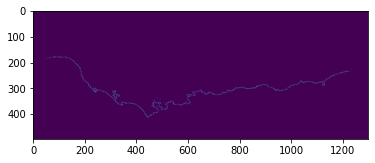

In [18]:
c = pd.read_csv('coast_id_stats_'+domain+'.csv',index_col=0)

#watershed that flow to different watersheds with lower max discharge
df1 = c.loc[(c.fws!=c.wshedid)&(c.Qtot>c.fq)].reset_index(drop=True)
fws = df1.fws.tolist()

fwsa = []
for ws in fws:
    try:
        if (ws == 0):
            fwsa.append(0)
        else:
            fwsa.append(int(c.area.loc[c.wshedid==ws]))
    except:
        fwsa.append(np.nan)
df1['fwsarea']=fwsa

# want to keep nan places because these flow to watersheds not in the watershed list
df2 = df1.loc[np.isnan(df1.fwsarea)]
df3 = df1.loc[~np.isnan(df1.fwsarea)]
df4 = df3.loc[df3.area<df3.fwsarea]
drop_list = df4.wshedid.tolist()
df5 = c.loc[~c.wshedid.isin(drop_list)]
df6 = df5.loc[df5.Qtot>0]

dfc = df6.reset_index(drop=True)
maskq = np.zeros([len(qhist.lat),len(qhist.lon)])
for i in range(len(dfc)):
    maskq[dfc.latidx[i],dfc.lonidx[i]]=1
plt.figure()
plt.imshow(maskq)
# add mask to ds
qhist["maskq"]=(['lat', 'lon'],  maskq)

In [89]:
QQhist = qhist.totq.isel(lev=0).where(qhist.maskq==1)
QhistSUM = QQhist.sum(dim=['lat','lon'])
QQfut = qfut.totq.isel(lev=0).where(qhist.maskq==1)
QfutSUM = QQfut.sum(dim=['lat','lon'])

Text(0.5, 1.0, 'BEAU coastal Q [$m^3$]')

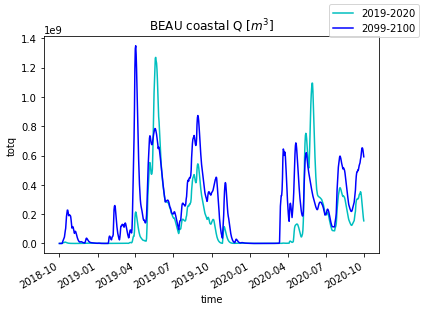

In [90]:
fig, ax = plt.subplots(1)
QhistSUM.plot(ax=ax,c='c',label=yrlabel_hist)
QfutSUM.plot(ax=ax,c='b',label=yrlabel_fut)
fig.legend()
ax.set_title('BEAU coastal Q [$m^3$]')

In [91]:
fig.savefig(domain+'_Q_'+yrlabel_hist+'_'+yrlabel_fut+'.png',dpi=300)

In [5]:
# open watershed data
wd = open_CtlDataset(wsd_ctl)
wd

<xarray.Dataset>
Dimensions:  (time: 1, lev: 1, lat: 496, lon: 1298)
Coordinates:
  * time     (time) datetime64[ns] 2011-10-01
  * lev      (lev) float64 1.0
  * lat      (lat) float32 1.96e+06 1.961e+06 1.962e+06 ... 2.454e+06 2.455e+06
  * lon      (lon) float32 -5.43e+05 -5.42e+05 -5.41e+05 ... 7.53e+05 7.54e+05
Data variables:
    dir      (time, lev, lat, lon) float32 dask.array<chunksize=(1, 1, 496, 1298), meta=np.ndarray>
    wshed    (time, lev, lat, lon) float32 dask.array<chunksize=(1, 1, 496, 1298), meta=np.ndarray>
    order    (time, lev, lat, lon) float32 dask.array<chunksize=(1, 1, 496, 1298), meta=np.ndarray>
Attributes:
    comment:  flow direction
    storage:  0
    title:    
    undef:    -9999.0
    pdef:     None

In [6]:
clsz=1000
# watershed area only including pixels with modeling output
h2oshed_area = int(wd.wshed.where(wd.wshed.isin(wsdlist)).count())*int(clsz)*int(clsz)
# number of pixels in watershed
h2oshed_num = int(wd.wshed.where(wd.wshed.isin(wsdlist)).count())
h2oshed_area,h2oshed_num

(221904000000, 221904)

In [7]:
# ctl files
prec_ctl_hist = SMoutputs_hist+'prec_'+yrlabel_hist+'.ctl'
prec_ctl_fut = SMoutputs_fut+'prec_'+yrlabel_fut+'.ctl'

# open prec data
phist = open_CtlDataset(prec_ctl_hist)
pslicehist = phist.prec.where((phist.prec>0)&(wd.wshed.isel(lev=0,time=0).isin(wsdlist)))
PhistSUM = pslicehist.sum(dim=['lat','lon'])*clsz*clsz
pcumsum = np.cumsum(PhistSUM.values)

pfut = open_CtlDataset(prec_ctl_fut)
pslicefut = pfut.prec.where((pfut.prec>0)&(wd.wshed.isel(lev=0,time=0).isin(wsdlist)))
PfutSUM = pslicefut.sum(dim=['lat','lon'])*clsz*clsz
pcumsumf = np.cumsum(PfutSUM.values)


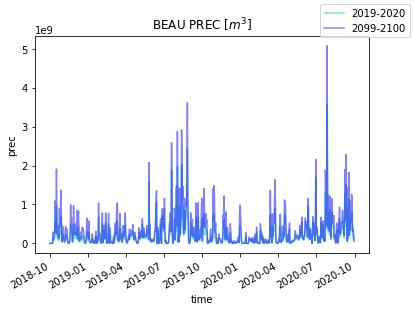

In [93]:
fig, ax = plt.subplots(1)
PhistSUM.plot(ax=ax,c='c',label=yrlabel_hist,alpha=0.5)
PfutSUM.plot(ax=ax,c='b',label=yrlabel_fut,alpha=0.5)
fig.legend()
ax.set_title('BEAU PREC [$m^3$]')
fig.savefig(domain+'_PREC_'+yrlabel_hist+'_'+yrlabel_fut+'.png',dpi=300)

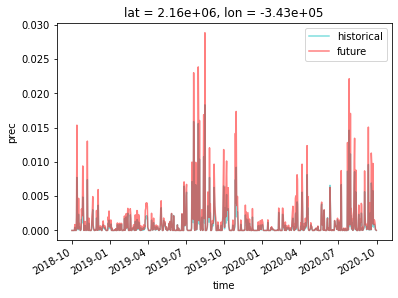

In [10]:
fig, ax = plt.subplots()
phist.prec.isel(lon=200,lat=200).plot(c='c',label='historical',alpha =0.5)
pfut.prec.isel(lon=200,lat=200).plot(c='r',label='future',alpha =0.5)
plt.legend()
fig.savefig(domain+'_mmP_pixel_wy2019-2020_wy2099-2100.png',dpi=300)

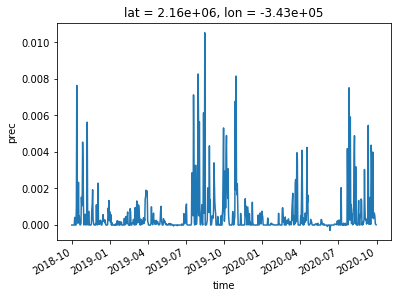

In [14]:
dif = pfut.prec.isel(lon=200,lat=200)-phist.prec.isel(lon=200,lat=200)
dif.plot()

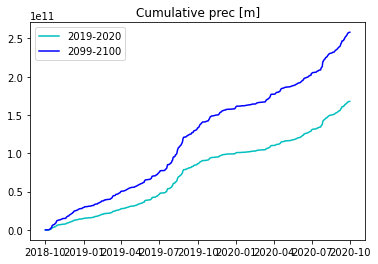

In [94]:
plt.plot(phist.time,pcumsum,c='c',label = yrlabel_hist)
plt.plot(phist.time,pcumsumf,c='b',label = yrlabel_fut)
plt.legend()
plt.title('Cumulative prec [m]')
plt.savefig(domain+'_cumPREC_'+yrlabel_hist+'_'+yrlabel_fut+'.png',dpi=300)

In [97]:
# ctl files
swe_ctl_hist = SMoutputs_hist+'swed_'+yrlabel_hist+'.ctl'
swe_ctl_fut = SMoutputs_fut+'swed_'+yrlabel_fut+'.ctl'

# open swe data
shist = open_CtlDataset(swe_ctl_hist)
sslicehist = shist.swed.where((shist.swed>-9999)&(wd.wshed.isel(lev=0,time=0).isin(wsdlist)))
shistSUM = sslicehist.sum(dim=['lat','lon'])*clsz*clsz

sfut = open_CtlDataset(swe_ctl_fut)
sslicefut = sfut.swed.where((sfut.swed>-9999)&(wd.wshed.isel(lev=0,time=0).isin(wsdlist)))
sfutSUM = sslicefut.sum(dim=['lat','lon'])*clsz*clsz


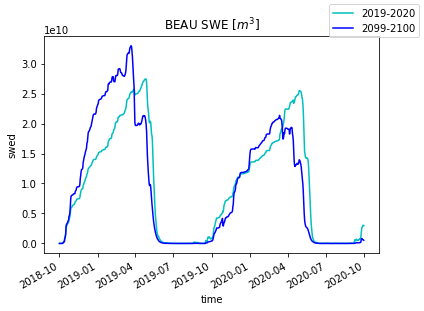

In [98]:
fig, ax = plt.subplots(1)
shistSUM.plot(ax=ax,c='c',label=yrlabel_hist)
sfutSUM.plot(ax=ax,c='b',label=yrlabel_fut)
fig.legend()
ax.set_title('BEAU SWE [$m^3$]')
fig.savefig(domain+'_SWE_'+yrlabel_hist+'_'+yrlabel_fut+'.png',dpi=300)

In [8]:
# ctl files
temp_ctl_hist = SMoutputs_hist+'tair_'+yrlabel_hist+'.ctl'
temp_ctl_fut = SMoutputs_fut+'tair_'+yrlabel_fut+'.ctl'

# open prec data
thist = open_CtlDataset(temp_ctl_hist)
tslicehist = thist.tair.where((thist.tair>-9999)&(wd.wshed.isel(lev=0,time=0).isin(wsdlist)))
thistSUM = tslicehist.mean(dim=['lat','lon'])

tfut = open_CtlDataset(temp_ctl_fut)
tslicefut = tfut.tair.where((tfut.tair>-9999)&(wd.wshed.isel(lev=0,time=0).isin(wsdlist)))
tfutSUM = tslicefut.mean(dim=['lat','lon'])


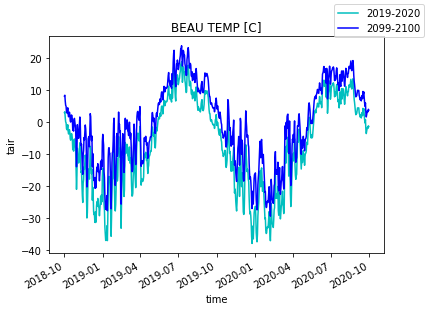

In [100]:
fig, ax = plt.subplots(1)
thistSUM.plot(ax=ax,c='c',label=yrlabel_hist)
tfutSUM.plot(ax=ax,c='b',label=yrlabel_fut)
fig.legend()
ax.set_title('BEAU TEMP [C]')
fig.savefig(domain+'_T_'+yrlabel_hist+'_'+yrlabel_fut+'.png',dpi=300)

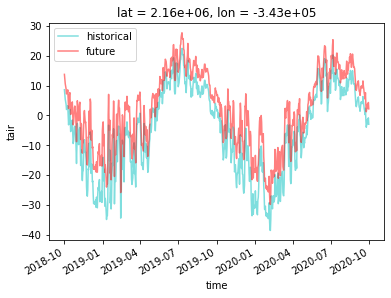

In [12]:
fig, ax = plt.subplots()
thist.tair.isel(lon=200,lat=200).plot(c='c',label='historical',alpha =0.5)
tfut.tair.isel(lon=200,lat=200).plot(c='r',label='future',alpha =0.5)
plt.legend()
fig.savefig(domain+'_mmT_pixel_wy2019-2020_wy2099-2100.png',dpi=300)

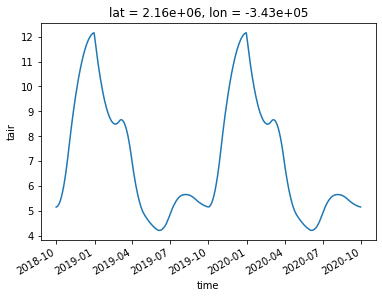

In [13]:
dif = tfut.tair.isel(lon=200,lat=200)-thist.tair.isel(lon=200,lat=200)
dif.plot()

In [56]:
pslicehist = phist.prec.where((phist.prec>0)&(wd.wshed.isel(lev=0,time=0).isin(wsdlist)))
PhistSUM = pslicehist.sum(dim=['lat','lon'])
pcumsum = np.cumsum(PhistSUM.values)

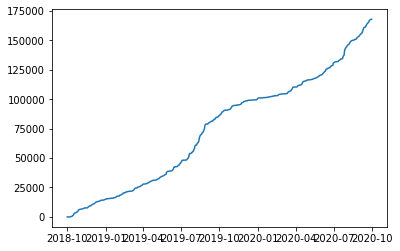

In [59]:
pcumsum = np.cumsum(PhistSUM.values)
plt.plot(phist.time,pcumsum)

In [42]:
pslicehist

<xarray.Dataset>
Dimensions:  (time: 731, lat: 496, lon: 1298)
Coordinates:
  * time     (time) datetime64[ns] 2018-10-01 2018-10-02 ... 2020-09-30
  * lat      (lat) float32 1.96e+06 1.961e+06 1.962e+06 ... 2.454e+06 2.455e+06
  * lon      (lon) float32 -5.43e+05 -5.42e+05 -5.41e+05 ... 7.53e+05 7.54e+05
    lev      float64 1.0
Data variables:
    prec     (time, lat, lon) float32 dask.array<chunksize=(1, 496, 1298), meta=np.ndarray>
Attributes:
    comment:  water-equivalent precipitation
    storage:  0
    title:    SnowModel
    undef:    -9999.0
    pdef:     None